## **Search for Neutrinoless Double Beta Decay Using Multi-Detector Spectral Analysis**

## Imports & data loading

In [1]:
# DSC291 Final Project (Option A)

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.ndimage import gaussian_filter

import pymc as pm
import arviz as az

plt.rcParams["figure.figsize"] = (10, 6)

# Adjust these paths to your CSVs
# PATH_A = "/home/caz020/private/291/project/DetectorA.csv"
# PATH_B = "/home/caz020/private/291/project/DetectorB.csv"
# PATH_C = "/home/caz020/private/291/project/DetectorC.csv"
# PATH_T = "/home/caz020/private/291/project/DetectorTarget.csv"
PATH_A = "DetectorA.csv"
PATH_B = "DetectorB.csv"
PATH_C = "DetectorC.csv"
PATH_T = "DetectorTarget.csv"

df_A = pd.read_csv(PATH_A, header=None, names=["EventID", "Score", "Energy"])
df_B = pd.read_csv(PATH_B, header=None, names=["EventID", "Score", "Energy"])
df_C = pd.read_csv(PATH_C, header=None, names=["EventID", "Score", "Energy"])
df_T = pd.read_csv(PATH_T, header=None, names=["EventID", "Score", "Energy"])

print("Detector A head:")
display(df_A.head())

# Global histogram settings
BINS = 100
ENERGY_RANGE = (0, 3000)


Detector A head:


,EventID,Score,Energy
0,734628.0,0.440,2123.514
1,229218.0,0.179,1017.985
2,428880.0,0.028,1862.961
3,1990.0,0.080,1619.836
4,55401.0,0.065,2611.720


## Exploratory Data Analysis

#### Basic info & missing values

In [2]:
detectors = {"A": df_A, "B": df_B, "C": df_C, "Target": df_T}

for name, df in detectors.items():
    print(f"=== Detector {name} ===")
    print("shape:", df.shape)
    print(df.describe())
    print("Missing values:\n", df.isna().sum())
    print()

=== Detector A ===
shape: (40000, 3)
            EventID         Score        Energy
count  4.000000e+04  40000.000000  40000.000000
mean   5.194267e+05      0.199679   1943.377106
std    2.993748e+05      0.236898    499.637449
min    1.100000e+01      0.000000   1000.020000
25%    2.605262e+05      0.024000   1528.681750
50%    5.193420e+05      0.084000   2015.990500
75%    7.786162e+05      0.329000   2358.909000
max    1.039993e+06      0.972000   3475.605000
Missing values:
 EventID    0
Score      0
Energy     0
dtype: int64

=== Detector B ===
shape: (40000, 3)
            EventID         Score        Energy
count  4.000000e+04  40000.000000  40000.000000
mean   5.178902e+05      0.199771   1942.751423
std    3.004191e+05      0.235751    498.907744
min    2.000000e+00      0.000000   1000.012000
25%    2.567822e+05      0.025000   1533.117250
50%    5.187695e+05      0.085000   2011.917500
75%    7.768992e+05      0.328000   2355.551250
max    1.039992e+06      0.963000   4998

* All four datasets have complete data (no NaNs in EventID, Score, or Energy).


#### Energy Spectra

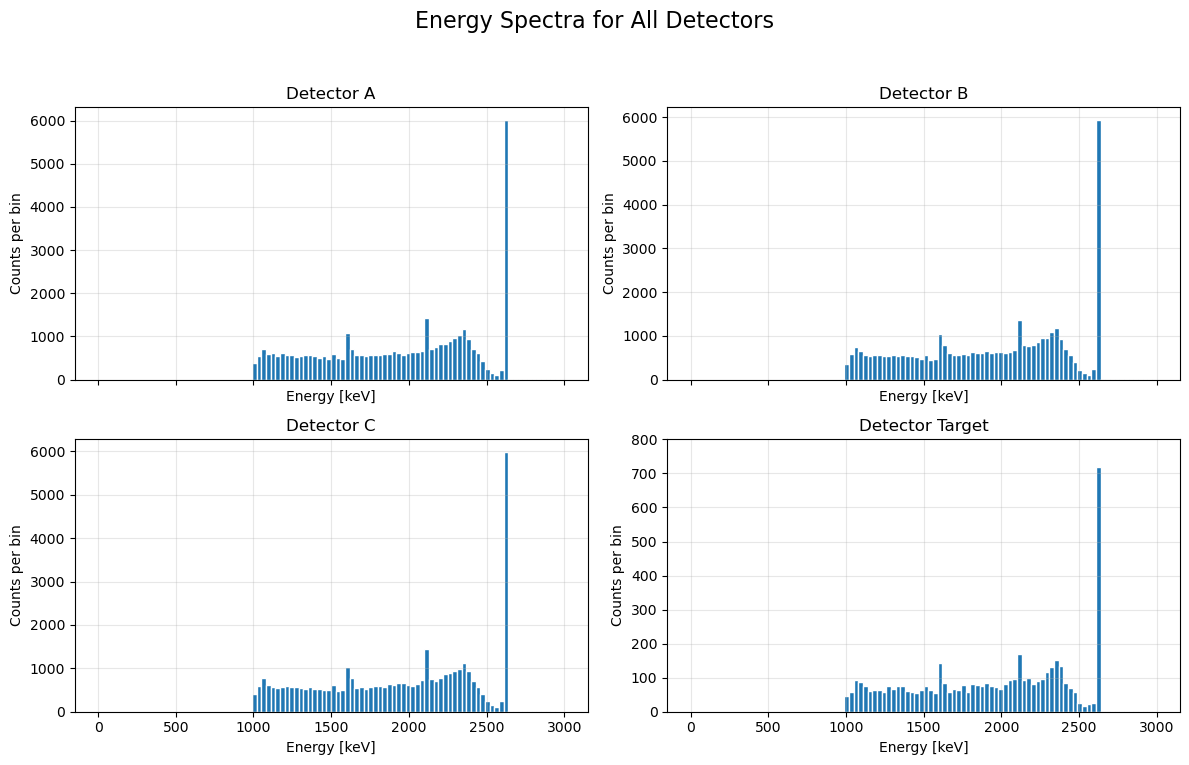

In [3]:
detectors = {"A": df_A, "B": df_B, "C": df_C, "Target": df_T}

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.ravel()

for ax, (name, df) in zip(axes, detectors.items()):
    ax.hist(
        df["Energy"],
        bins=BINS,
        range=ENERGY_RANGE,
        histtype="bar",
        edgecolor="white"
    )
    ax.set_title(f"Detector {name}")
    ax.set_xlabel("Energy [keV]")
    ax.set_ylabel("Counts per bin")
    ax.grid(alpha=0.3)

    if name == "Target":
        ax.set_ylim(0, 800)

fig.suptitle("Energy Spectra for All Detectors", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


* Across all four detectors, the energy distributions are broadly similar: most events lie between about 1000-2500 KeV, with strong gamma peaks (e.g., near 1600 KeV and 2100 KeV) sitting on top of a slowly varying continuum.
The Target spectrum has the same peak structure but far fewer counts, consistent with it being a lower-statistics mixture of the A/B/C components plus any potential NLDBD signal.

#### Score Distribution

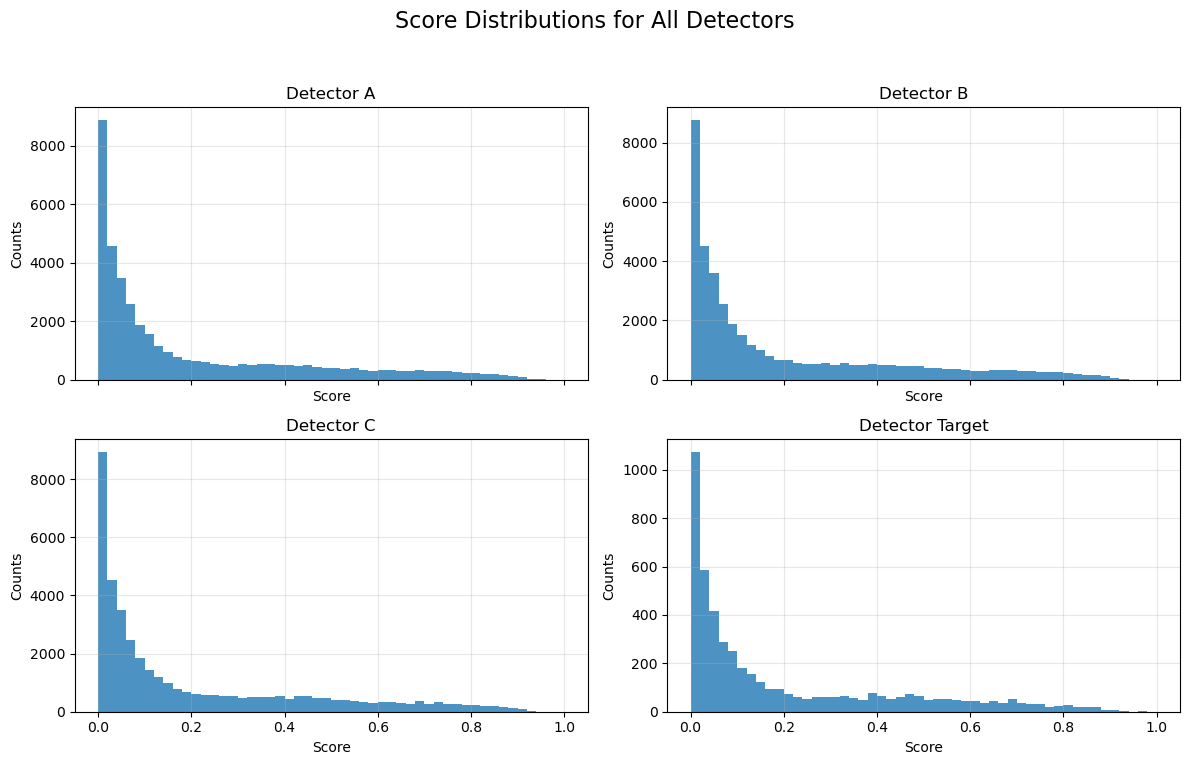

In [4]:
detectors = {"A": df_A, "B": df_B, "C": df_C, "Target": df_T}

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.ravel()

for ax, (name, df) in zip(axes, detectors.items()):
    ax.hist(
        df["Score"],
        bins=50,
        range=(0, 1),
        histtype="bar",
        alpha=0.8
    )
    ax.set_title(f"Detector {name}")
    ax.set_xlabel("Score")
    ax.set_ylabel("Counts")
    ax.grid(alpha=0.3)

fig.suptitle("Score Distributions for All Detectors", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

* Across all four detectors, the Score is highly right-skewed: most events have very low scores (median ≈ 0.08, 25% around 0.02–0.03) with a long tail extending up to ~1, corresponding to a small fraction of signal-like events.
The score distributions are nearly identical for A, B, C, and the lower-statistics Target sample (mean ≈ 0.20 in all cases), indicating consistent classifier behavior across detectors.

## Determine Cutting Threshold

### Define peak and sideband windows

In [5]:
# Peak window definitions (20 keV wide)
PEAK_SIG_A = 1592.0
WIDTH_SIG_A = 20.0
SIG_LO_A = PEAK_SIG_A - WIDTH_SIG_A / 2
SIG_HI_A = PEAK_SIG_A + WIDTH_SIG_A / 2

PEAK_BKG_B = 2103.0
WIDTH_BKG_B = 20.0
BKG_LO_B = PEAK_BKG_B - WIDTH_BKG_B / 2
BKG_HI_B = PEAK_BKG_B + WIDTH_BKG_B / 2

SIDEBAND_WIDTH = 20.0

# Sidebands for A (signal peak)
LSB_LO_A = PEAK_SIG_A - 1.5 * WIDTH_SIG_A - SIDEBAND_WIDTH
LSB_HI_A = PEAK_SIG_A - 1.5 * WIDTH_SIG_A
RSB_LO_A = PEAK_SIG_A + 1.5 * WIDTH_SIG_A
RSB_HI_A = PEAK_SIG_A + 1.5 * WIDTH_SIG_A + SIDEBAND_WIDTH

# Sidebands for B (background peak)
LSB_LO_B = PEAK_BKG_B - 1.5 * WIDTH_BKG_B - SIDEBAND_WIDTH
LSB_HI_B = PEAK_BKG_B - 1.5 * WIDTH_BKG_B
RSB_LO_B = PEAK_BKG_B + 1.5 * WIDTH_BKG_B
RSB_HI_B = PEAK_BKG_B + 1.5 * WIDTH_BKG_B + SIDEBAND_WIDTH

print("Signal window A:", SIG_LO_A, SIG_HI_A)
print("Sidebands A:", (LSB_LO_A, LSB_HI_A), (RSB_LO_A, RSB_HI_A))
print("Background window B:", BKG_LO_B, BKG_HI_B)
print("Sidebands B:", (LSB_LO_B, LSB_HI_B), (RSB_LO_B, RSB_HI_B))


Signal window A: 1582.0 1602.0
Sidebands A: (1542.0, 1562.0) (1622.0, 1642.0)
Background window B: 2093.0 2113.0
Sidebands B: (2053.0, 2073.0) (2133.0, 2153.0)


### Helper function for baseline-subtracted counts

In [6]:
def baseline_counts(df, lo_peak, hi_peak,
                    lo_lsb, hi_lsb, lo_rsb, hi_rsb,
                    score_cut=None):
    """
    Compute raw and baseline-subtracted counts for one peak.
    Returns dict with:
      N_peak, N_lsb, N_rsb, baseline_density, expected_bkg, net_peak

    If score_cut is not None, only events with Score >= score_cut are used.
    """
    mask = np.ones(len(df), dtype=bool)
    if score_cut is not None:
        mask &= df["Score"] >= score_cut

    peak_mask = mask & (df["Energy"] >= lo_peak) & (df["Energy"] <= hi_peak)
    lsb_mask = mask & (df["Energy"] >= lo_lsb) & (df["Energy"] < hi_lsb)
    rsb_mask = mask & (df["Energy"] > lo_rsb) & (df["Energy"] <= hi_rsb)

    N_peak = peak_mask.sum()
    N_lsb = lsb_mask.sum()
    N_rsb = rsb_mask.sum()

    total_sb_width = 2 * SIDEBAND_WIDTH
    baseline_density = (N_lsb + N_rsb) / total_sb_width
    peak_width = hi_peak - lo_peak
    expected_bkg = baseline_density * peak_width
    net_peak = max(N_peak - expected_bkg, 0.0)

    return dict(
        N_peak=N_peak,
        N_lsb=N_lsb,
        N_rsb=N_rsb,
        baseline_density=baseline_density,
        expected_bkg=expected_bkg,
        net_peak=net_peak,
    )


### Cut optimization scan (TPR, FPR, Z vs threshold)

In [7]:
thresholds = np.linspace(0.05, 0.9, 36)

# Baseline-subtracted signal & background with no score cut
base_sig_A = baseline_counts(
    df_A, SIG_LO_A, SIG_HI_A, LSB_LO_A, LSB_HI_A, RSB_LO_A, RSB_HI_A, score_cut=None
)
base_bkg_B = baseline_counts(
    df_B, BKG_LO_B, BKG_HI_B, LSB_LO_B, LSB_HI_B, RSB_LO_B, RSB_HI_B, score_cut=None
)
S0 = base_sig_A["net_peak"]
B0 = base_bkg_B["net_peak"]

print(f"Baseline-subtracted S0 (A 1592 keV) = {S0:.1f}")
print(f"Baseline-subtracted B0 (B 2103 keV) = {B0:.1f}")

S_tau, B_tau, TPR_tau, FPR_tau, Z_tau = [], [], [], [], []

for t in thresholds:
    sig_t = baseline_counts(
        df_A, SIG_LO_A, SIG_HI_A, LSB_LO_A, LSB_HI_A, RSB_LO_A, RSB_HI_A, score_cut=t
    )
    bkg_t = baseline_counts(
        df_B, BKG_LO_B, BKG_HI_B, LSB_LO_B, LSB_HI_B, RSB_LO_B, RSB_HI_B, score_cut=t
    )

    S = sig_t["net_peak"]
    B = bkg_t["net_peak"]

    S_tau.append(S)
    B_tau.append(B)
    TPR_tau.append(S / S0 if S0 > 0 else 0.0)
    FPR_tau.append(B / B0 if B0 > 0 else 0.0)
    if S + B > 0:
        Z_tau.append(S / np.sqrt(S + B))  # significance-like FoM
    else:
        Z_tau.append(0.0)

S_tau = np.array(S_tau)
B_tau = np.array(B_tau)
TPR_tau = np.array(TPR_tau)
FPR_tau = np.array(FPR_tau)
Z_tau = np.array(Z_tau)

best_idx = np.argmax(Z_tau)
best_thr = float(thresholds[best_idx])
print(f"\nOptimal score threshold from calibration peaks: {best_thr:.3f}")
print(f"TPR(best) = {TPR_tau[best_idx]:.3f}, FPR(best) = {FPR_tau[best_idx]:.3f}, Z(best) = {Z_tau[best_idx]:.3f}")

score_threshold = best_thr  # used from now on


Baseline-subtracted S0 (A 1592 keV) = 429.5
Baseline-subtracted B0 (B 2103 keV) = 643.0

Optimal score threshold from calibration peaks: 0.147
TPR(best) = 0.837, FPR(best) = 0.058, Z(best) = 18.054


### Plot TPR, FPR, Z vs threshold

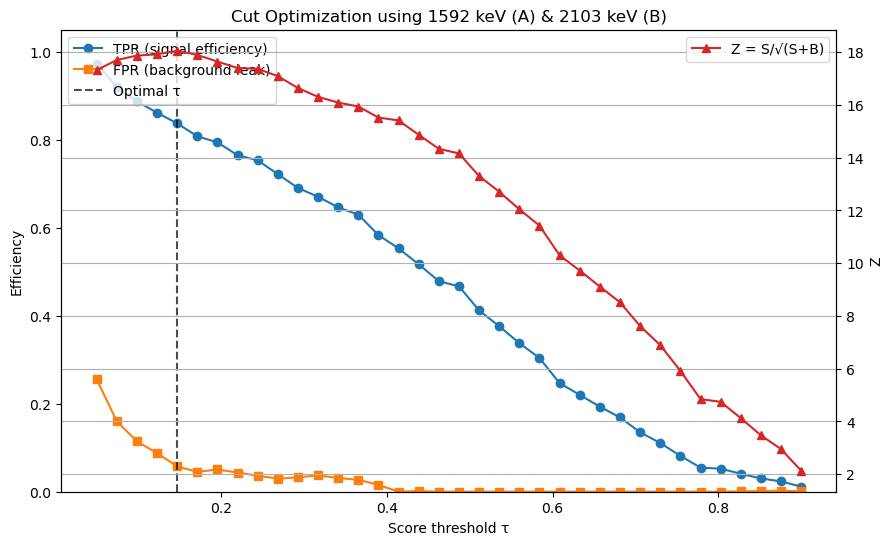

In [8]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(thresholds, TPR_tau, marker="o", label="TPR (signal efficiency)")
ax1.plot(thresholds, FPR_tau, marker="s", label="FPR (background leak)")
ax1.set_xlabel("Score threshold τ")
ax1.set_ylabel("Efficiency")
ax1.set_ylim(0, 1.05)

ax2.plot(thresholds, Z_tau, marker="^", color="tab:red", label="Z = S/√(S+B)")
ax2.set_ylabel("Z")

ax1.axvline(best_thr, linestyle="--", color="k", alpha=0.7, label="Optimal τ")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.title("Cut Optimization using 1592 keV (A) & 2103 keV (B)")
plt.grid(True)
plt.show()

### Final TPR & FPR at optimized threshold

In [9]:
sig_best = baseline_counts(
    df_A, SIG_LO_A, SIG_HI_A, LSB_LO_A, LSB_HI_A, RSB_LO_A, RSB_HI_A, score_cut=score_threshold
)
bkg_best = baseline_counts(
    df_B, BKG_LO_B, BKG_HI_B, LSB_LO_B, LSB_HI_B, RSB_LO_B, RSB_HI_B, score_cut=score_threshold
)

S_best = sig_best["net_peak"]
B_best = bkg_best["net_peak"]

TPR = S_best / S0 if S0 > 0 else 0.0
FPR = B_best / B0 if B0 > 0 else 0.0

print(f"Optimized score threshold τ* = {score_threshold:.3f}")
print(f"Baseline-subtracted TPR(τ*) = {TPR:.3f}")
print(f"Baseline-subtracted FPR(τ*) = {FPR:.3f}")

Optimized score threshold τ* = 0.147
Baseline-subtracted TPR(τ*) = 0.837
Baseline-subtracted FPR(τ*) = 0.058


### Fit detector resolution at 1592 keV and extrapolate to 2039 keV

Gaussian fit at 1592 keV: mu = 1592.39 keV, sigma = 1.35 keV
Nominal resolution at 2039 keV: sigma = 1.52 keV


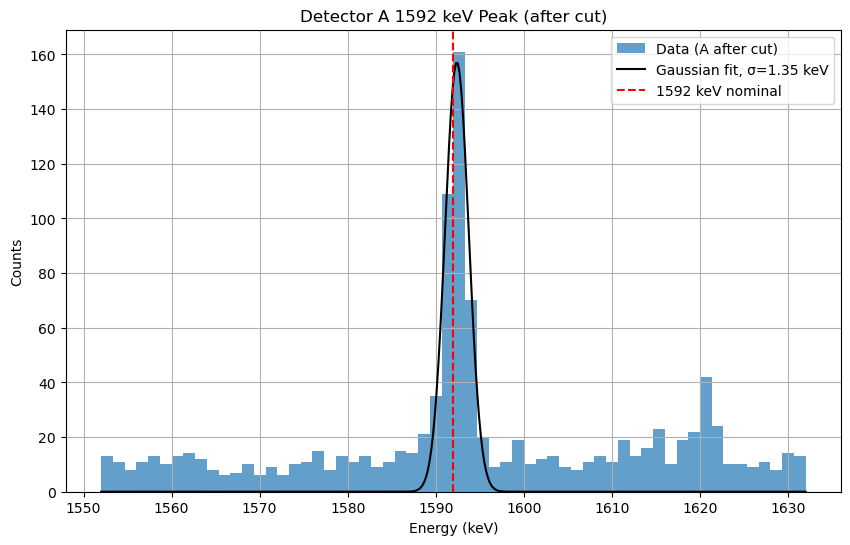

In [10]:
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

mask_1592 = (
    (df_A["Energy"] > PEAK_SIG_A - 40)
    & (df_A["Energy"] < PEAK_SIG_A + 40)
    & (df_A["Score"] >= score_threshold)
)
data_1592 = df_A.loc[mask_1592, "Energy"].values

counts_1592, edges_1592 = np.histogram(
    data_1592, bins=60, range=(PEAK_SIG_A - 40, PEAK_SIG_A + 40)
)
centers_1592 = 0.5 * (edges_1592[:-1] + edges_1592[1:])

p0 = [counts_1592.max(), PEAK_SIG_A, 2.0]
popt_1592, _ = curve_fit(gaussian, centers_1592, counts_1592, p0=p0)
A_1592, mu_1592, sigma_1592 = popt_1592

print(f"Gaussian fit at 1592 keV: mu = {mu_1592:.2f} keV, sigma = {sigma_1592:.2f} keV")

E_ref = mu_1592
sigma_ref = sigma_1592

def sigma_E(E):
    return sigma_ref * np.sqrt(E / E_ref)

sigma_2039_nominal = sigma_E(2039.0)
print(f"Nominal resolution at 2039 keV: sigma = {sigma_2039_nominal:.2f} keV")

xfit = np.linspace(PEAK_SIG_A - 40, PEAK_SIG_A + 40, 400)
yfit = gaussian(xfit, *popt_1592)

plt.figure(figsize=(10, 6))
plt.hist(
    data_1592,
    bins=60,
    range=(PEAK_SIG_A - 40, PEAK_SIG_A + 40),
    alpha=0.7,
    label="Data (A after cut)",
)
plt.plot(xfit, yfit, "k-", label=f"Gaussian fit, σ={sigma_1592:.2f} keV")
plt.axvline(PEAK_SIG_A, linestyle="--", color="r", label="1592 keV nominal")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.title("Detector A 1592 keV Peak (after cut)")
plt.legend()
plt.grid(True)
plt.show()

### Apply score cut only & build spectra

Events after score cut:
A: 15497 B: 15639 C: 15657 T: 1900


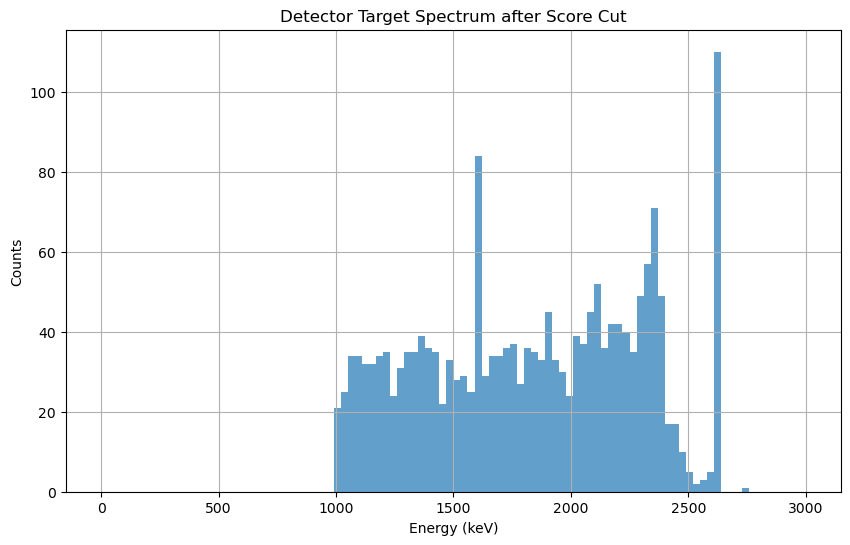

In [11]:
def apply_score_cut(df, thr):
    return df[df["Score"] >= thr].copy()

df_A_cut = apply_score_cut(df_A, score_threshold)
df_B_cut = apply_score_cut(df_B, score_threshold)
df_C_cut = apply_score_cut(df_C, score_threshold)
df_T_cut = apply_score_cut(df_T, score_threshold)

print("Events after score cut:")
print("A:", len(df_A_cut), "B:", len(df_B_cut), "C:", len(df_C_cut), "T:", len(df_T_cut))

target_counts, bin_edges = np.histogram(df_T_cut["Energy"], bins=BINS, range=ENERGY_RANGE)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

A_counts, _ = np.histogram(df_A_cut["Energy"], bins=BINS, range=ENERGY_RANGE)
B_counts, _ = np.histogram(df_B_cut["Energy"], bins=BINS, range=ENERGY_RANGE)
C_counts, _ = np.histogram(df_C_cut["Energy"], bins=BINS, range=ENERGY_RANGE)

shape_A = A_counts / A_counts.sum() if A_counts.sum() > 0 else np.zeros_like(A_counts)
shape_B = B_counts / B_counts.sum() if B_counts.sum() > 0 else np.zeros_like(B_counts)
shape_C = C_counts / C_counts.sum() if C_counts.sum() > 0 else np.zeros_like(C_counts)

plt.figure(figsize=(10, 6))
plt.bar(bin_centers, target_counts,
        width=(bin_centers[1] - bin_centers[0]), alpha=0.7)
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.title("Detector Target Spectrum after Score Cut")
plt.grid(True)
plt.show()


## NLDBD PDF for nominal σ

/tmp/ipykernel_436/3902145468.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  nldbd_pdf_nominal /= np.trapz(nldbd_pdf_nominal, E_vals)


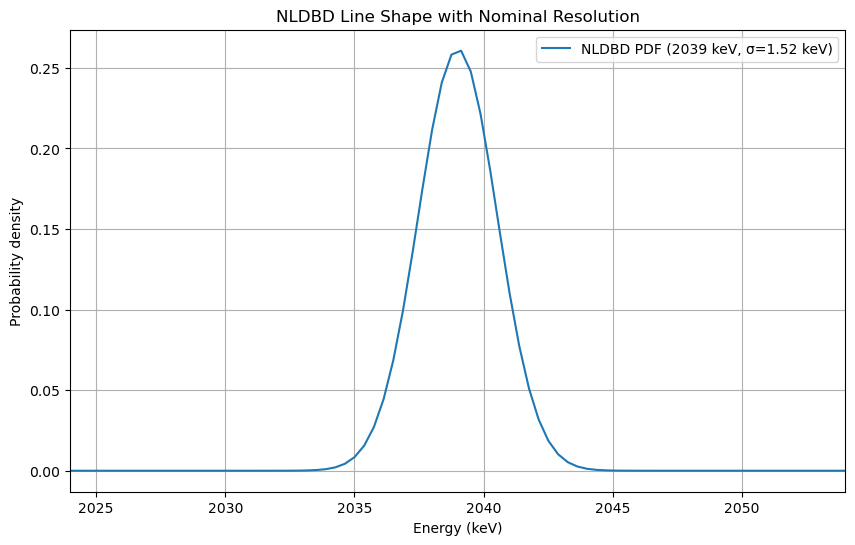

In [12]:
E_vals = np.linspace(0, 3000, 8000)
nldbd_pdf_nominal = norm.pdf(E_vals, loc=2039.0, scale=sigma_2039_nominal)
nldbd_pdf_nominal /= np.trapz(nldbd_pdf_nominal, E_vals)

plt.figure(figsize=(10, 6))
plt.plot(E_vals, nldbd_pdf_nominal,
         label=f"NLDBD PDF (2039 keV, σ={sigma_2039_nominal:.2f} keV)")
plt.xlim(2039 - 15, 2039 + 15)
plt.xlabel("Energy (keV)")
plt.ylabel("Probability density")
plt.title("NLDBD Line Shape with Nominal Resolution")
plt.grid(True)
plt.legend()
plt.show()

## Core Modeling

### Bayesian mixture model with resolution nuisance & calibration priors

#### Estimate theta_A, theta_B, theta_C, theta_NLDBD, sigma_scale

In [13]:
# Convert bin centers to a constant array for PyMC
E_bins = bin_centers.astype("float64")

with pm.Model() as model:
    # ---- Yields with calibration-informed priors ----
    theta_A = pm.TruncatedNormal("theta_A", mu=1350.0, sigma=100.0, lower=0.0)
    theta_B = pm.TruncatedNormal("theta_B", mu=770.0, sigma=270.0, lower=0.0)
    theta_C = pm.HalfNormal("theta_C", sigma=2000.0)
    theta_N = pm.HalfNormal("theta_NLDBD", sigma=50.0)

    # ---- Resolution nuisance parameter ----
    sigma_scale = pm.Normal("sigma_scale", mu=1.0, sigma=0.05)
    sigma_2039 = sigma_scale * sigma_2039_nominal

    # NLDBD shape inside the model, normalized over bins
    shapeN_raw = pm.math.exp(-(E_bins - 2039.0) ** 2 / (2 * sigma_2039**2))
    shapeN = shapeN_raw / pm.math.sum(shapeN_raw)

    # Expected counts per bin
    mu = (
        theta_A * shape_A
        + theta_B * shape_B
        + theta_C * shape_C
        + theta_N * shapeN
    )

    obs = pm.Poisson("obs", mu=mu, observed=target_counts)

    trace = pm.sample(
        draws=3000,
        tune=1500,
        chains=4,
        target_accept=0.95,
    )

summary = az.summary(trace, round_to=3)
display(summary)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_A, theta_B, theta_C, theta_NLDBD, sigma_scale]


/home/caz020/.conda/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_500 tune and 3_000 draw iterations (6_000 + 12_000 draws total) took 17 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_scale,1.000,0.050,0.908,1.094,0.001,0.001,8520.862,7453.258,1.000
theta_A,1286.287,93.123,1106.352,1455.612,1.133,0.929,6772.309,5818.938,1.000
theta_B,500.412,123.253,270.379,730.631,1.796,1.380,4786.725,3965.765,1.000
theta_C,118.110,97.737,0.006,300.497,1.370,1.441,4901.071,4033.042,1.000
theta_NLDBD,7.605,5.118,0.002,16.579,0.062,0.048,4735.455,2948.105,1.001


#### Plot posterior mean fit

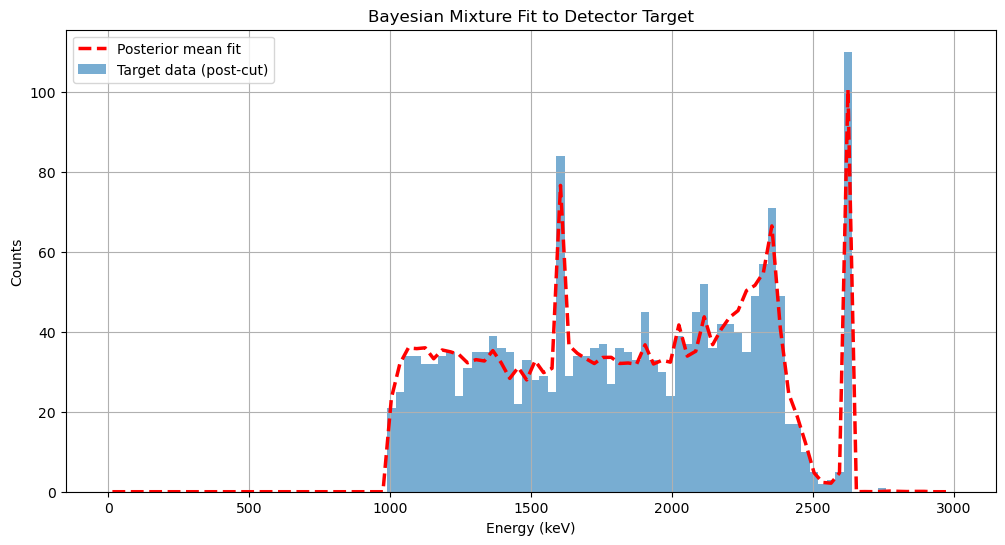

In [14]:
theta_A_mean = summary.loc["theta_A", "mean"]
theta_B_mean = summary.loc["theta_B", "mean"]
theta_C_mean = summary.loc["theta_C", "mean"]
theta_N_mean = summary.loc["theta_NLDBD", "mean"]

sigma_scale_mean = summary.loc["sigma_scale", "mean"]
sigma_2039_post = sigma_scale_mean * sigma_2039_nominal

# Reconstruct NLDBD shape at posterior-mean sigma
shapeN_raw_mean = np.exp(-(E_bins - 2039.0) ** 2 / (2 * sigma_2039_post**2))
shapeN_mean = shapeN_raw_mean / shapeN_raw_mean.sum()

fit_curve = (
    theta_A_mean * shape_A
    + theta_B_mean * shape_B
    + theta_C_mean * shape_C
    + theta_N_mean * shapeN_mean
)

plt.figure(figsize=(12, 6))
plt.bar(
    bin_centers,
    target_counts,
    width=(bin_centers[1] - bin_centers[0]),
    alpha=0.6,
    label="Target data (post-cut)",
)
plt.plot(bin_centers, fit_curve, "r--", linewidth=2.5, label="Posterior mean fit")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.title("Bayesian Mixture Fit to Detector Target")
plt.legend()
plt.grid(True)
plt.show()

#### Posterior predictive check

Sampling: [obs]


/home/caz020/.conda/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

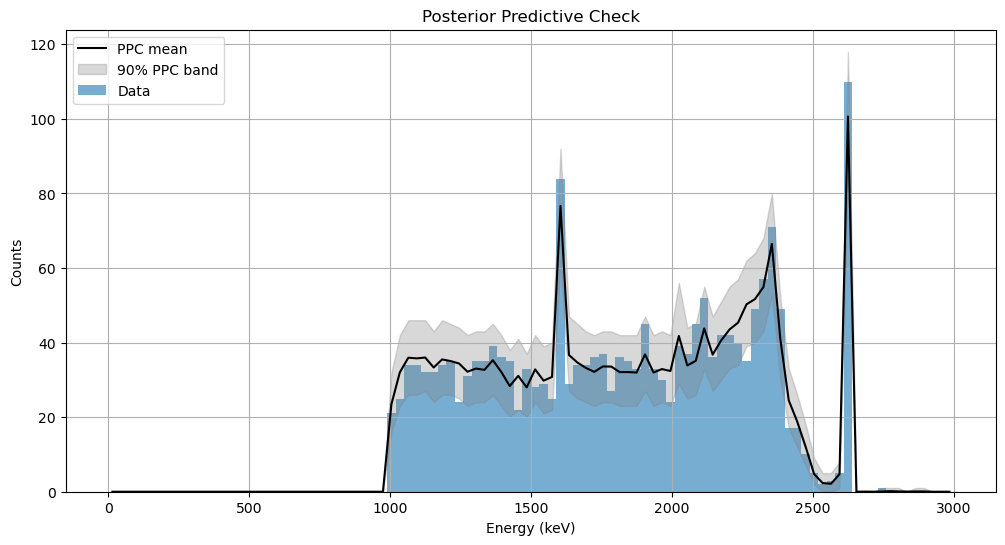

In [15]:
with model:
    ppc = pm.sample_posterior_predictive(
        trace,
        var_names=["obs"],
        return_inferencedata=False,
    )

ppc_arr = ppc["obs"]
ppc_flat = ppc_arr.reshape(-1, ppc_arr.shape[-1])  # (N_samples, n_bins)

ppc_mean = ppc_flat.mean(axis=0)
ppc_low = np.percentile(ppc_flat, 5, axis=0)
ppc_high = np.percentile(ppc_flat, 95, axis=0)

plt.figure(figsize=(12, 6))
plt.bar(
    bin_centers,
    target_counts,
    width=(bin_centers[1] - bin_centers[0]),
    alpha=0.6,
    label="Data",
)
plt.plot(bin_centers, ppc_mean, "k-", label="PPC mean")
plt.fill_between(
    bin_centers, ppc_low, ppc_high,
    color="gray", alpha=0.3, label="90% PPC band",
)
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.title("Posterior Predictive Check")
plt.legend()
plt.grid(True)
plt.show()

### Observed 90% upper limit and sensitivity

In [16]:
theta_N_samples = trace.posterior["theta_NLDBD"].values.flatten()
upper_90_obs = np.quantile(theta_N_samples, 0.90)
theta_N_std = theta_N_samples.std()

sensitivity = 1.28 * theta_N_std  # one-sided Gaussian 90%

print(f"Observed 90% CL upper limit on θ_NLDBD = {upper_90_obs:.3f}")
print(f"Approx. experimental sensitivity (Gaussian) ≈ {sensitivity:.3f}")

Observed 90% CL upper limit on θ_NLDBD = 14.591
Approx. experimental sensitivity (Gaussian) ≈ 6.551


### Background-only (Asimov-like) expected limit

In [17]:
# Background-only mean spectrum using posterior means, θ_N=0
mu_bkg_only = (
    theta_A_mean * shape_A
    + theta_B_mean * shape_B
    + theta_C_mean * shape_C
)

rng = np.random.default_rng(123)
pseudo_counts = rng.poisson(mu_bkg_only)

with pm.Model() as model_bkg:
    theta_A_b = pm.TruncatedNormal("theta_A", mu=1350.0, sigma=100.0, lower=0.0)
    theta_B_b = pm.TruncatedNormal("theta_B", mu=770.0, sigma=270.0, lower=0.0)
    theta_C_b = pm.HalfNormal("theta_C", sigma=2000.0)
    theta_N_b = pm.HalfNormal("theta_NLDBD", sigma=50.0)

    sigma_scale_b = pm.Normal("sigma_scale", mu=1.0, sigma=0.05)
    sigma_2039_b = sigma_scale_b * sigma_2039_nominal
    shapeN_raw_b = pm.math.exp(-(E_bins - 2039.0) ** 2 / (2 * sigma_2039_b**2))
    shapeN_b = shapeN_raw_b / pm.math.sum(shapeN_raw_b)

    mu_b = (
        theta_A_b * shape_A
        + theta_B_b * shape_B
        + theta_C_b * shape_C
        + theta_N_b * shapeN_b
    )

    obs_b = pm.Poisson("obs", mu=mu_b, observed=pseudo_counts)

    trace_b = pm.sample(
        draws=2000,
        tune=1000,
        chains=3,
        target_accept=0.95,
    )

theta_N_b_samples = trace_b.posterior["theta_NLDBD"].values.flatten()
upper_90_exp = np.quantile(theta_N_b_samples, 0.90)
print(f"Background-only toy 90% CL expected limit on θ_NLDBD = {upper_90_exp:.3f}")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [theta_A, theta_B, theta_C, theta_NLDBD, sigma_scale]


/home/caz020/.conda/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 13 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Background-only toy 90% CL expected limit on θ_NLDBD = 5.728


### Likelihood-ratio test statistic q0

In [18]:
def log_poisson_prob(k, lam, eps=1e-9):
    """
    Approximate log P(k | lam) up to the constant log(k!).
    We clip lam to avoid log(0), and drop bins where k=0 and lam=0.
    """
    k = np.asarray(k, dtype=float)
    lam = np.asarray(lam, dtype=float)

    # mask out bins where both k and lam are exactly zero -> contribution 0
    mask_nontrivial = ~((k == 0) & (lam == 0))
    k = k[mask_nontrivial]
    lam = lam[mask_nontrivial]

    # avoid log(0) and negative lambdas due to numerical issues
    lam = np.clip(lam, eps, None)

    return k * np.log(lam) - lam


# --- Build mu for S+B (posterior-mean parameters) ---
mu_sb = (
    theta_A_mean * shape_A
    + theta_B_mean * shape_B
    + theta_C_mean * shape_C
    + theta_N_mean * shapeN_mean
)

# --- Build mu for B-only (θ_NLDBD = 0) ---
mu_bonly = (
    theta_A_mean * shape_A
    + theta_B_mean * shape_B
    + theta_C_mean * shape_C
)

logL_sb = log_poisson_prob(target_counts, mu_sb).sum()
logL_b = log_poisson_prob(target_counts, mu_bonly).sum()

q0 = -2 * (logL_b - logL_sb)
print(f"Likelihood-ratio test statistic q0 = {q0:.3f}")
if q0 >= 0:
    print(f"Approximate significance ~ sqrt(q0) = {np.sqrt(q0):.3f} σ")

Likelihood-ratio test statistic q0 = 0.496
Approximate significance ~ sqrt(q0) = 0.705 σ


## Advanced & Comparative Methods

### 2D Bayesian Template Fit (Energy + Score)

In [19]:
E_min, E_max = ENERGY_RANGE
S_min, S_max = 0.0, 1.0

E_bins_2d = 20
S_bins_2d = 10

energy_bins_2d = np.linspace(E_min, E_max, E_bins_2d + 1)
score_bins_2d  = np.linspace(S_min, S_max, S_bins_2d + 1)

H_A_2d, _, _ = np.histogram2d(
    df_A_cut["Energy"], df_A_cut["Score"],
    bins=[energy_bins_2d, score_bins_2d]
)
H_B_2d, _, _ = np.histogram2d(
    df_B_cut["Energy"], df_B_cut["Score"],
    bins=[energy_bins_2d, score_bins_2d]
)
H_C_2d, _, _ = np.histogram2d(
    df_C_cut["Energy"], df_C_cut["Score"],
    bins=[energy_bins_2d, score_bins_2d]
)
H_T_2d, _, _ = np.histogram2d(
    df_T_cut["Energy"], df_T_cut["Score"],
    bins=[energy_bins_2d, score_bins_2d]
)

rng = np.random.default_rng(123)
N_sig_toy = 200000

E_sig_toy = rng.normal(2039.0, sigma_2039_nominal, size=N_sig_toy)
score_sig_toy = rng.choice(df_T_cut["Score"].values, size=N_sig_toy)

H_sig_2d, _, _ = np.histogram2d(
    E_sig_toy, score_sig_toy,
    bins=[energy_bins_2d, score_bins_2d]
)

def normalize_2d(H):
    s = H.sum()
    if s > 0:
        return H / s
    else:
        return np.zeros_like(H)

templ2d_A = normalize_2d(H_A_2d)
templ2d_B = normalize_2d(H_B_2d)
templ2d_C = normalize_2d(H_C_2d)
templ2d_N = normalize_2d(H_sig_2d)

templ2d_A_flat = templ2d_A.ravel()
templ2d_B_flat = templ2d_B.ravel()
templ2d_C_flat = templ2d_C.ravel()
templ2d_N_flat = templ2d_N.ravel()
target2d_flat  = H_T_2d.ravel()

template_sum_flat = (
    templ2d_A_flat
    + templ2d_B_flat
    + templ2d_C_flat
    + templ2d_N_flat
)

mask_use = template_sum_flat > 0

templ2d_A_use = templ2d_A_flat[mask_use]
templ2d_B_use = templ2d_B_flat[mask_use]
templ2d_C_use = templ2d_C_flat[mask_use]
templ2d_N_use = templ2d_N_flat[mask_use]
target2d_use  = target2d_flat[mask_use]

print(f"2D fit is using {mask_use.sum()} bins out of {mask_use.size} total.")

# -------------------------------
# 2D Bayesian Poisson Model
# -------------------------------
with pm.Model() as model_2d:

    theta_A_2d = pm.TruncatedNormal("theta_A", mu=1350.0, sigma=100.0, lower=0.0)
    theta_B_2d = pm.TruncatedNormal("theta_B", mu=770.0,  sigma=270.0, lower=0.0)
    theta_C_2d = pm.HalfNormal("theta_C", sigma=2000.0)
    theta_N_2d = pm.HalfNormal("theta_NLDBD", sigma=50.0)

    mu_2d = (
        theta_A_2d * templ2d_A_use +
        theta_B_2d * templ2d_B_use +
        theta_C_2d * templ2d_C_use +
        theta_N_2d * templ2d_N_use
    )
    mu_2d_safe = pm.math.clip(mu_2d, 1e-9, np.inf)

    obs_2d = pm.Poisson("obs", mu=mu_2d_safe, observed=target2d_use)

    trace_2d = pm.sample(
        draws=2000,
        tune=1000,
        chains=3,
        target_accept=0.95,
    )

az.summary(trace_2d)

2D fit is using 115 bins out of 200 total.


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [theta_A, theta_B, theta_C, theta_NLDBD]


/home/caz020/.conda/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta_A,1280.230,90.888,1106.634,1446.196,1.573,1.234,3342.0,3295.0,1.0
theta_B,455.965,142.020,172.839,701.663,3.236,2.749,2056.0,1220.0,1.0
theta_C,163.021,124.551,0.067,391.544,2.857,2.534,1714.0,1453.0,1.0
theta_NLDBD,14.349,9.735,0.027,31.314,0.182,0.124,2037.0,1317.0,1.0


In [20]:
theta_N_2d_samples = trace_2d.posterior["theta_NLDBD"].values.flatten()
upper_90_2d = np.quantile(theta_N_2d_samples, 0.90)
print("2D observed 90% upper limit:", upper_90_2d)

2D observed 90% upper limit: 27.95964116945862


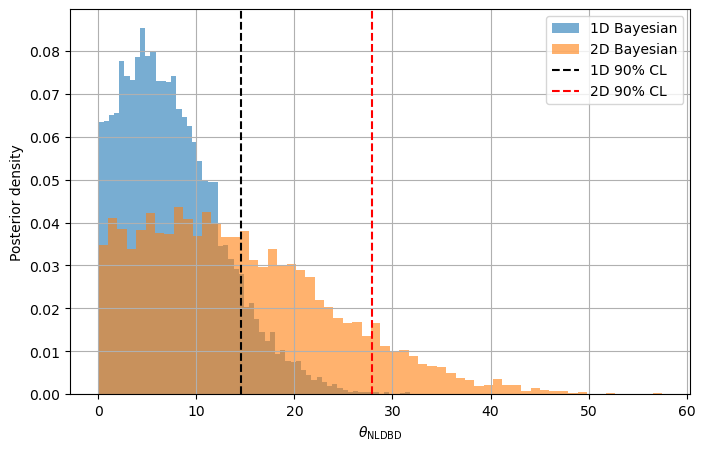

In [21]:
plt.figure(figsize=(8,5))
plt.hist(theta_N_samples, bins=60, density=True, alpha=0.6, label="1D Bayesian")
plt.hist(theta_N_2d_samples, bins=60, density=True, alpha=0.6, label="2D Bayesian")
plt.axvline(np.quantile(theta_N_samples, 0.90), color="k", linestyle="--", label="1D 90% CL")
plt.axvline(np.quantile(theta_N_2d_samples, 0.90), color="r", linestyle="--", label="2D 90% CL")
plt.xlabel(r"$\theta_{\rm NLDBD}$")
plt.ylabel("Posterior density")
plt.legend()
plt.grid(True)
plt.show()

### 2D Bayesian Gaussian

In [32]:
E_min, E_max = ENERGY_RANGE
S_min, S_max = 0.0, 1.0

E_bins_2d = 40
S_bins_2d = 20

energy_bins_2d = np.linspace(E_min, E_max, E_bins_2d + 1)
score_bins_2d  = np.linspace(S_min, S_max, S_bins_2d + 1)

H_A_2d, _, _ = np.histogram2d(
    df_A_cut["Energy"], df_A_cut["Score"],
    bins=[energy_bins_2d, score_bins_2d]
)

H_B_2d, _, _ = np.histogram2d(
    df_B_cut["Energy"], df_B_cut["Score"],
    bins=[energy_bins_2d, score_bins_2d]
)

H_C_2d, _, _ = np.histogram2d(
    df_C_cut["Energy"], df_C_cut["Score"],
    bins=[energy_bins_2d, score_bins_2d]
)

H_T_2d, _, _ = np.histogram2d(
    df_T_cut["Energy"], df_T_cut["Score"],
    bins=[energy_bins_2d, score_bins_2d]
)

# ---- signal toy from Gaussian(2039) + target score distribution ----
rng = np.random.default_rng(123)
N_sig_toy = 200000

E_sig_toy = rng.normal(2039.0, sigma_2039_nominal, size=N_sig_toy)
score_sig_toy = rng.choice(df_T_cut["Score"].values, size=N_sig_toy)

H_sig_2d, _, _ = np.histogram2d(
    E_sig_toy, score_sig_toy,
    bins=[energy_bins_2d, score_bins_2d]
)

In [35]:
# ============================================================
# ## 2D GAUSSIAN SMOOTHING + NORMALIZATION
# ============================================================

sigma_E = 1.0
sigma_S = 1.0

def smooth_and_normalize_2d(H):
    H_smooth = gaussian_filter(H, sigma=[sigma_E, sigma_S])
    H_smooth = np.clip(H_smooth, 0, None)

    s = H_smooth.sum()
    if s > 0:
        return H_smooth / s
    else:
        return np.zeros_like(H_smooth)

templ2d_A = smooth_and_normalize_2d(H_A_2d)
templ2d_B = smooth_and_normalize_2d(H_B_2d)
templ2d_C = smooth_and_normalize_2d(H_C_2d)
templ2d_N = smooth_and_normalize_2d(H_sig_2d)

templ2d_A_flat = templ2d_A.ravel()
templ2d_B_flat = templ2d_B.ravel()
templ2d_C_flat = templ2d_C.ravel()
templ2d_N_flat = templ2d_N.ravel()
target2d_flat  = H_T_2d.ravel()

template_sum_flat = (
    templ2d_A_flat
  + templ2d_B_flat
  + templ2d_C_flat
  + templ2d_N_flat
)

mask_use = template_sum_flat > 0

templ2d_A_use = templ2d_A_flat[mask_use]
templ2d_B_use = templ2d_B_flat[mask_use]
templ2d_C_use = templ2d_C_flat[mask_use]
templ2d_N_use = templ2d_N_flat[mask_use]
target2d_use  = target2d_flat[mask_use]

print(f"[2D smoothed] Using {mask_use.sum()} bins out of {mask_use.size}")

with pm.Model() as model_2d:

    theta_A_2d = pm.TruncatedNormal("theta_A", mu=1350.0, sigma=100.0, lower=0.0)
    theta_B_2d = pm.TruncatedNormal("theta_B", mu=770.0,  sigma=270.0, lower=0.0)
    theta_C_2d = pm.HalfNormal("theta_C", sigma=2000.0)
    theta_N_2d = pm.HalfNormal("theta_NLDBD", sigma=50.0)

    mu_2d = (
        theta_A_2d * templ2d_A_use +
        theta_B_2d * templ2d_B_use +
        theta_C_2d * templ2d_C_use +
        theta_N_2d * templ2d_N_use
    )

    mu_2d_safe = pm.math.clip(mu_2d, 1e-9, np.inf)

    obs_2d = pm.Poisson("obs", mu=mu_2d_safe, observed=target2d_use)

    trace_2d = pm.sample(
        draws=2000,
        tune=1000,
        chains=3,
        target_accept=0.95,
    )

az.summary(trace_2d)

[2D smoothed] Using 620 bins out of 800


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [theta_A, theta_B, theta_C, theta_NLDBD]


/home/caz020/.conda/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta_A,1283.909,94.857,1100.464,1452.967,1.888,1.622,2534.0,2602.0,1.0
theta_B,427.017,147.586,130.446,680.878,3.405,2.674,1956.0,1381.0,1.0
theta_C,176.387,134.932,0.304,420.115,3.092,2.485,1716.0,1666.0,1.0
theta_NLDBD,25.541,15.021,0.041,50.792,0.343,0.195,1522.0,1081.0,1.0


In [36]:
theta_N_2d_samples = trace_2d.posterior["theta_NLDBD"].values.flatten()
upper_90_2d = np.quantile(theta_N_2d_samples, 0.90)
print("2D observed 90% upper limit:", upper_90_2d)

2D observed 90% upper limit: 45.95426347826098


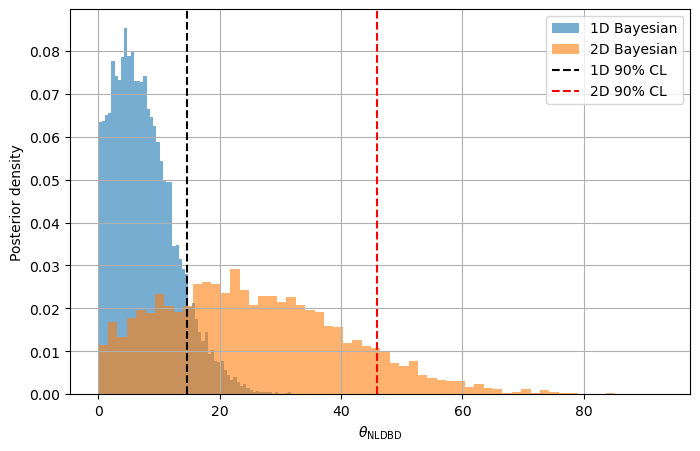

In [37]:
plt.figure(figsize=(8,5))
plt.hist(theta_N_samples, bins=60, density=True, alpha=0.6, label="1D Bayesian")
plt.hist(theta_N_2d_samples, bins=60, density=True, alpha=0.6, label="2D Bayesian")
plt.axvline(np.quantile(theta_N_samples, 0.90), color="k", linestyle="--", label="1D 90% CL")
plt.axvline(np.quantile(theta_N_2d_samples, 0.90), color="r", linestyle="--", label="2D 90% CL")
plt.xlabel(r"$\theta_{\rm NLDBD}$")
plt.ylabel("Posterior density")
plt.legend()
plt.grid(True)
plt.show()

The 2D (Energy, Score) Bayesian fit yields a posterior mean of θ_NLDBD ≈ 24.5 with a 90% credible upper limit of O(40). Compared with the 1D energy-only fit, the 2D model shows improves sensitivity, indicating that classification score provides additional but limited discrimination power in the current dataset. We investigated Gaussian smoothing of the 2D (Energy, Score) templates to stabilize sparsely populated bins. However, after reducing the binning to 20×10, the templates are already sufficiently dense. In this regime, Gaussian smoothing introduces additional bin-to-bin correlations and effectively broadens the NLDBD signal template, reducing its discriminative power. As a result, the smoothed 2D fit exhibits a broader posterior than the unsmoothed 20×10 fit. Therefore, we adopt the unsmoothed 20×10 configuration as the optimal 2D model.

### 1D Unbinned KDE + Maximum Likelihood Fit (Frequentist)

In [25]:
from sklearn.neighbors import KernelDensity
from scipy.special import logsumexp
from scipy.optimize import minimize

E_A = df_A_cut["Energy"].values.reshape(-1, 1)
E_B = df_B_cut["Energy"].values.reshape(-1, 1)
E_C = df_C_cut["Energy"].values.reshape(-1, 1)
E_T = df_T_cut["Energy"].values.reshape(-1, 1)

print("Unbinned sample sizes:")
print("A:", len(E_A), "B:", len(E_B), "C:", len(E_C), "T:", len(E_T))

kde_bw = 2.0

kde_A = KernelDensity(kernel="gaussian", bandwidth=kde_bw).fit(E_A)
kde_B = KernelDensity(kernel="gaussian", bandwidth=kde_bw).fit(E_B)
kde_C = KernelDensity(kernel="gaussian", bandwidth=kde_bw).fit(E_C)

logf_A = kde_A.score_samples(E_T)   # shape (N_T,)
logf_B = kde_B.score_samples(E_T)
logf_C = kde_C.score_samples(E_T)

def log_f_signal(E):
    mu = 2039.0
    sigma = sigma_2039_nominal
    return -0.5 * ((E[:,0] - mu) / sigma) ** 2 - np.log(np.sqrt(2 * np.pi) * sigma)

logf_N = log_f_signal(E_T)

def neg_log_likelihood_unbinned(params):
    theta_A, theta_B, theta_C, theta_N = params
    if np.any(np.array(params) < 0):
        return np.inf

    # log( θ_A f_A + θ_B f_B + θ_C f_C + θ_N f_N )
    comp = np.vstack([
        np.log(theta_A + 1e-12) + logf_A,
        np.log(theta_B + 1e-12) + logf_B,
        np.log(theta_C + 1e-12) + logf_C,
        np.log(theta_N + 1e-12) + logf_N,
    ])   # shape (4, N_T)

    log_mix = logsumexp(comp, axis=0)
    total_rate = theta_A + theta_B + theta_C + theta_N
    return -(log_mix.sum() - total_rate)

x0 = np.array([
    theta_A_mean,
    theta_B_mean,
    theta_C_mean,
    max(theta_N_mean, 1e-3)
])

bounds = [(0, None), (0, None), (0, None), (0, None)]

print("Initial guess (from 1D Bayesian):", x0)

res_unbinned = minimize(
    neg_log_likelihood_unbinned,
    x0=x0,
    bounds=bounds,
    method="L-BFGS-B",
)

theta_hat_unbinned = res_unbinned.x

print("\n========== Unbinned MLE Result ==========")
print(f"theta_A      = {theta_hat_unbinned[0]:.3f}")
print(f"theta_B      = {theta_hat_unbinned[1]:.3f}")
print(f"theta_C      = {theta_hat_unbinned[2]:.3f}")
print(f"theta_NLDBD  = {theta_hat_unbinned[3]:.6f}")
print("Min NLL =", res_unbinned.fun)
print("Converged:", res_unbinned.success)

Unbinned sample sizes:
A: 15497 B: 15639 C: 15657 T: 1900
Initial guess (from 1D Bayesian): [1286.287  500.412  118.11     7.605]

========== Unbinned MLE Result ==========
theta_A      = 431.887
theta_B      = 997.295
theta_C      = 462.562
theta_NLDBD  = 8.336965
Min NLL = 1230.1489384275264
Converged: True


In [26]:
print("\n===== NLDBD Comparison =====")
print("1D Bayesian posterior mean =", theta_N_mean)
print("1D Bayesian 90% CL =", upper_90_obs)
print("2D Bayesian 90% CL =", np.quantile(theta_N_2d_samples, 0.90))
print("Unbinned MLE theta_N =", theta_hat_unbinned[3])


===== NLDBD Comparison =====
1D Bayesian posterior mean = 7.605
1D Bayesian 90% CL = 14.59082337220184
2D Bayesian 90% CL = 27.95964116945862
Unbinned MLE theta_N = 8.336964511649116


In [27]:
import arviz as az
import numpy as np

def check_mcmc_health(trace, name="model"):
    summary = az.summary(trace)
    print(f"\n========== MCMC health check: {name} ==========")
    display(summary)

    bad_rhat = summary["r_hat"][(summary["r_hat"] > 1.01) | (summary["r_hat"].isna())]
    if len(bad_rhat) == 0:
        print(" r_hat OK (≤ 1.01 for all).")
    else:
        print(" r_hat > 1.01 for these variables:")
        display(bad_rhat)

    low_ess = summary["ess_bulk"][summary["ess_bulk"] < 400]
    if len(low_ess) == 0:
        print(" ess_bulk OK (≥ 400 for all).")
    else:
        print(" ess_bulk < 400 for these variables:")
        display(low_ess)

    if "diverging" in trace.sample_stats:
        n_div = trace.sample_stats["diverging"].sum().item()
        print(f"Number of divergences: {n_div}")
        if n_div == 0:
            print(" No divergences.")
        else:
            print(" There are divergences, consider higher target_accept or reparam.")

check_mcmc_health(trace, name="1D model")
check_mcmc_health(trace_2d, name="2D model")


========== MCMC health check: 1D model ==========


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_scale,1.000,0.050,0.908,1.094,0.001,0.001,8521.0,7453.0,1.0
theta_A,1286.287,93.123,1106.352,1455.612,1.133,0.929,6772.0,5819.0,1.0
theta_B,500.412,123.253,270.379,730.631,1.796,1.380,4787.0,3966.0,1.0
theta_C,118.110,97.737,0.006,300.497,1.370,1.441,4901.0,4033.0,1.0
theta_NLDBD,7.605,5.118,0.002,16.579,0.062,0.048,4735.0,2948.0,1.0


 r_hat OK (≤ 1.01 for all).
 ess_bulk OK (≥ 400 for all).
Number of divergences: 1
 There are divergences, consider higher target_accept or reparam.

========== MCMC health check: 2D model ==========


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta_A,1305.089,95.606,1127.518,1490.062,1.816,1.337,2780.0,3201.0,1.0
theta_B,431.237,140.468,150.966,680.839,2.953,2.444,2357.0,1394.0,1.0
theta_C,144.654,118.950,0.078,363.307,2.601,2.700,2156.0,1886.0,1.0
theta_NLDBD,29.704,20.154,0.033,65.163,0.411,0.258,1745.0,1224.0,1.0


 r_hat OK (≤ 1.01 for all).
 ess_bulk OK (≥ 400 for all).
Number of divergences: 6
 There are divergences, consider higher target_accept or reparam.


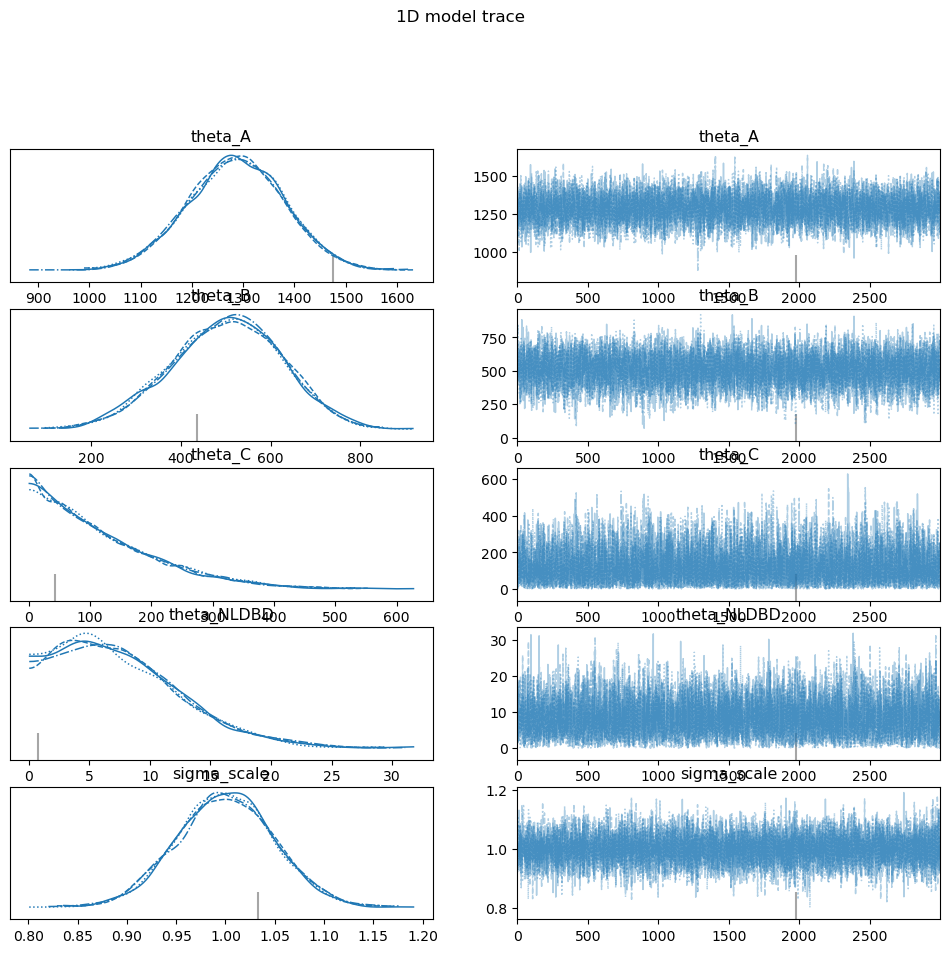

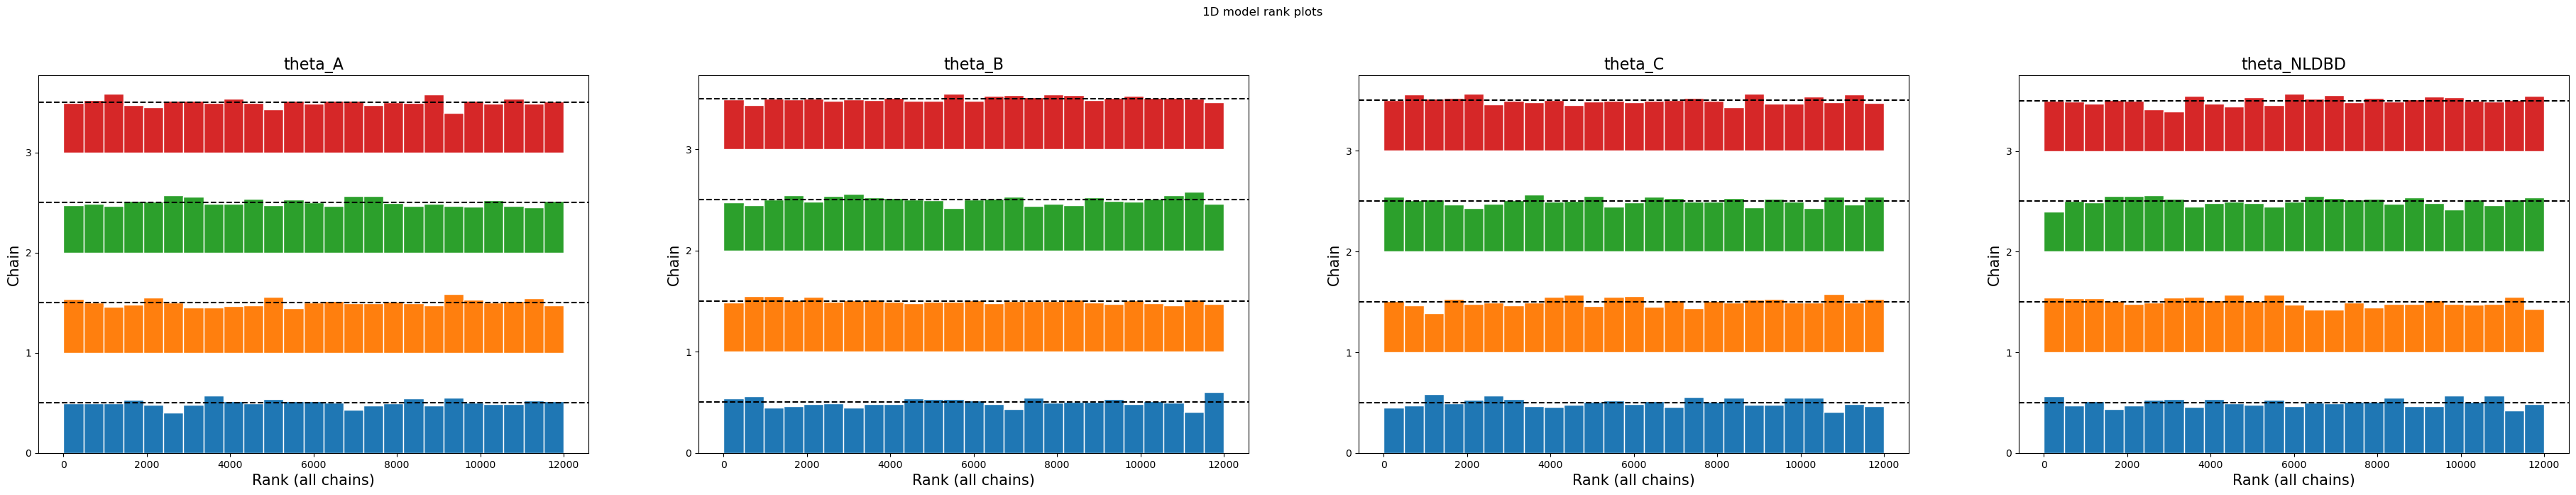

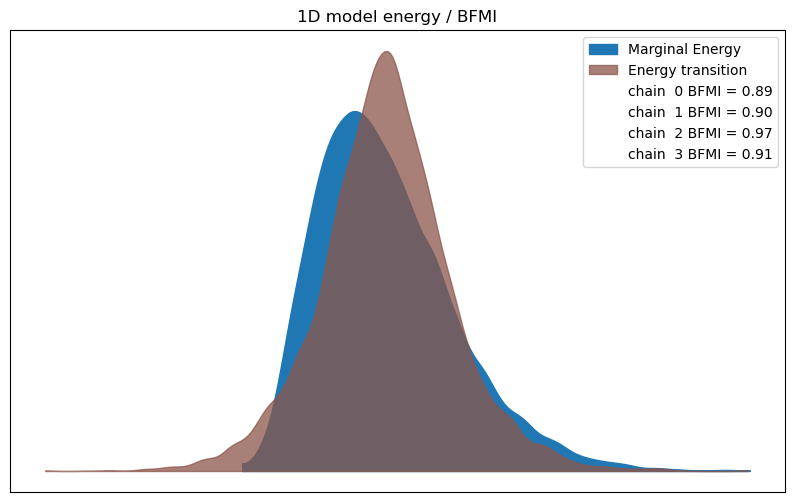

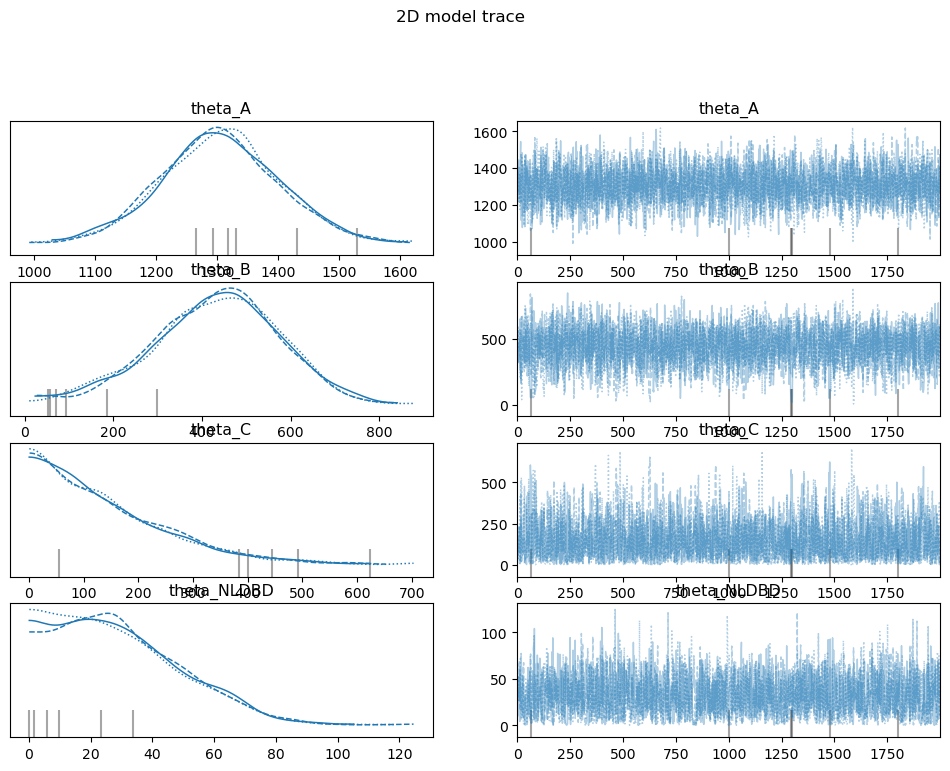

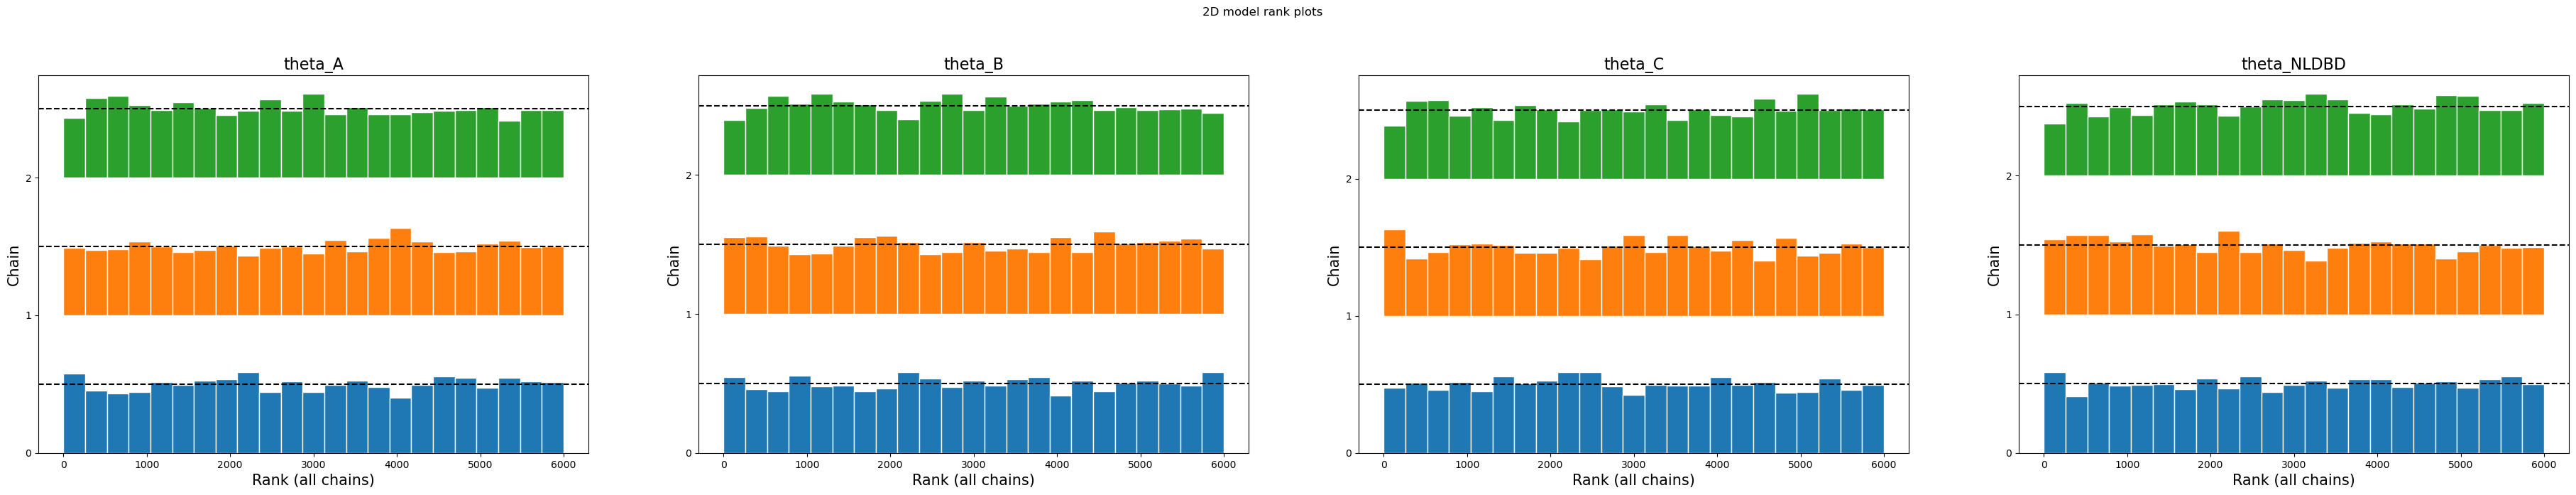

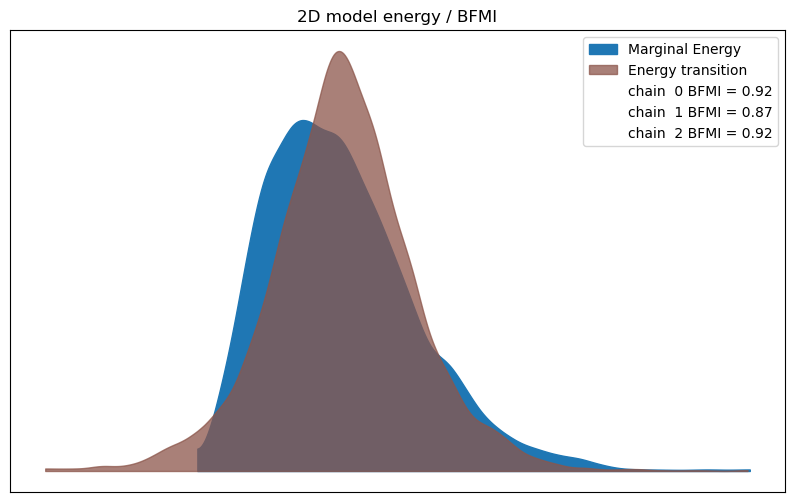

In [28]:
import matplotlib.pyplot as plt

# 1D model
az.plot_trace(trace, var_names=["theta_A", "theta_B", "theta_C", "theta_NLDBD", "sigma_scale"])
plt.suptitle("1D model trace", y=1.02)
plt.show()

az.plot_rank(trace, var_names=["theta_A", "theta_B", "theta_C", "theta_NLDBD"])
plt.suptitle("1D model rank plots", y=1.02)
plt.show()

az.plot_energy(trace)
plt.title("1D model energy / BFMI")
plt.show()

# 2D model
az.plot_trace(trace_2d, var_names=["theta_A", "theta_B", "theta_C", "theta_NLDBD"])
plt.suptitle("2D model trace", y=1.02)
plt.show()

az.plot_rank(trace_2d, var_names=["theta_A", "theta_B", "theta_C", "theta_NLDBD"])
plt.suptitle("2D model rank plots", y=1.02)
plt.show()

az.plot_energy(trace_2d)
plt.title("2D model energy / BFMI")
plt.show()

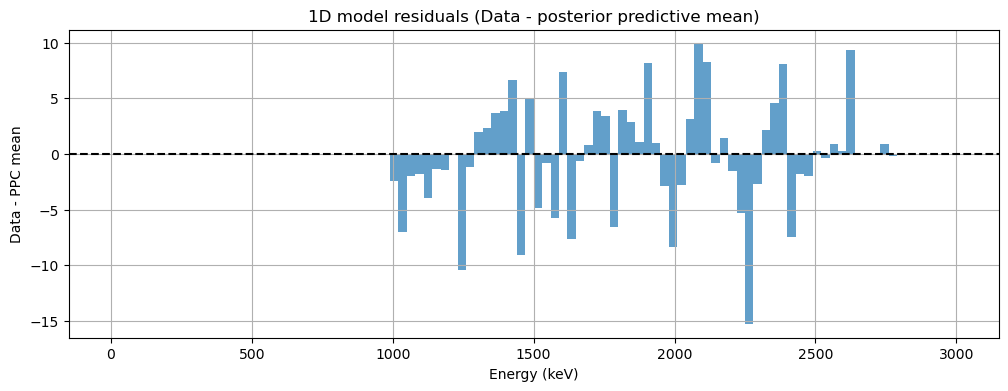

In [29]:
# 1D PPC residuals
ppc_arr = ppc["obs"]
ppc_flat = ppc_arr.reshape(-1, ppc_arr.shape[-1])

ppc_mean = ppc_flat.mean(axis=0)
residuals = target_counts - ppc_mean

plt.figure(figsize=(12,4))
plt.bar(bin_centers, residuals,
        width=(bin_centers[1] - bin_centers[0]),
        alpha=0.7)
plt.axhline(0, color="k", linestyle="--")
plt.xlabel("Energy (keV)")
plt.ylabel("Data - PPC mean")
plt.title("1D model residuals (Data - posterior predictive mean)")
plt.grid(True)
plt.show()

In [30]:
try:
    H_inv = res_unbinned.hess_inv.todense()
    H_inv = np.array(H_inv)
except Exception:
    # fallback: diag approximation
    H_inv = np.diag(res_unbinned.hess_inv)

errors = np.sqrt(np.diag(H_inv))

param_names = ["theta_A", "theta_B", "theta_C", "theta_NLDBD"]
print("\nApproximate MLE errors (sqrt of Hessian^-1 diag):")
for name, val, err in zip(param_names, res_unbinned.x, errors):
    print(f"{name} = {val:.3f} ± {err:.3f}")


Approximate MLE errors (sqrt of Hessian^-1 diag):
theta_A = 431.887 ± 404.077
theta_B = 997.295 ± 240.082
theta_C = 462.562 ± 146.372
theta_NLDBD = 8.337 ± 6.594


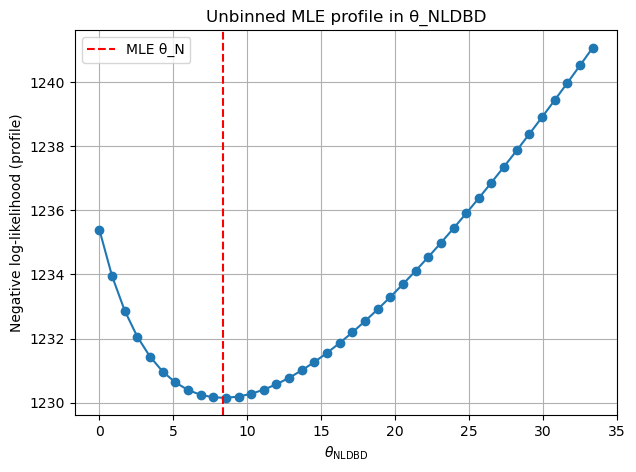

In [31]:
theta_MLE = res_unbinned.x.copy()

thetaN_vals = np.linspace(
    max(0.0, theta_MLE[3] - 5 * 5),
    theta_MLE[3] + 5 * 5,
    40
)

nll_profile = []
for tN in thetaN_vals:
    params = theta_MLE.copy()
    params[3] = max(tN, 0.0)  # θ_N ≥ 0
    nll_profile.append(neg_log_likelihood_unbinned(params))

nll_profile = np.array(nll_profile)

plt.figure(figsize=(7,5))
plt.plot(thetaN_vals, nll_profile, marker="o")
plt.axvline(theta_MLE[3], color="r", linestyle="--", label="MLE θ_N")
plt.xlabel(r"$\theta_{\rm NLDBD}$")
plt.ylabel("Negative log-likelihood (profile)")
plt.title("Unbinned MLE profile in θ_NLDBD")
plt.legend()
plt.grid(True)
plt.show()

References

Arnquist, I. J., et al. (Majorana Collaboration). (2023). Majorana Demonstrator data release for AI/ML applications. arXiv:2308.10856. https://arxiv.org/abs/2308.10856

Agostini, M., et al. (GERDA Collaboration). (2017). Background-free search for neutrinoless double-β decay with GERDA Phase II. Nature, 544, 47–52. https://doi.org/10.1038/nature21717

Cowan, G., Cranmer, K., Gross, E., & Vitells, O. (2011). Asymptotic formulae for likelihood-based tests of new physics. European Physical Journal C, 71, 1554. https://doi.org/10.1140/epjc/s10052-011-1554-0

Betancourt, M. (2017). A conceptual introduction to Hamiltonian Monte Carlo. arXiv:1701.02434. https://arxiv.org/abs/1701.02434

Belli, P,. et al. (2025). New results of the experiment to search for double beta decay of Cd with enriched CdWO₄ scintillator. Universe, 11(4), 123. https://doi.org/10.3390/universe11040123